## Barotropic streamfunction
Based on
https://github.com/OceansAus/cosima-cookbook/blob/master/ContributedExamples/BarotropicStreamFunction.ipynb

In [1]:
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import os,sys
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
figdir = ''
def savefigure(fname):
#     plt.savefig(os.path.join(figdir, fname),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
# model data paths:
model = 'access-om2-01'
expt = '01deg_jra55v13_ryf8485_spinup6'
DataDir = os.path.join('/g/data3/hh5/tmp/cosima/', model)
expdir = os.path.join(DataDir, expt)

# length of climatology (may be corrected below):
n_years = 10

dataFileList = glob(os.path.join(expdir, 'output*/ocean/ocean_month.nc'))
dataFileList.sort()

# update n_years to avoid exceeding available data
if model=='mom025':
    filesPerYear = 1
elif model=='mom01v5':
    filesPerYear = 4
elif model=='access-om2-01':
    filesPerYear = 12
total_years = len(dataFileList)/filesPerYear  # NB: typically not an integer
n_years = min(n_years, int(total_years) )
n_files = n_years*filesPerYear
firstfile = int(total_years-n_years)*filesPerYear  # start of calendar year

dataFileListClim = dataFileList[firstfile:firstfile+n_files]
# dataFileListClim = dataFileList[165:285]  # to compare with https://github.com/OceansAus/cosima-cookbook/blob/master/ContributedExamples/BarotropicStreamFunction.ipynb

In [4]:
# get model grid data:
gridFileList = glob(os.path.join(expdir, 'output*/ocean/ocean_grid.nc'))
gridFileList.sort()
ncFile = Dataset(gridFileList[0],'r')
xt_ocean = ncFile.variables['xt_ocean'][...]
yt_ocean = ncFile.variables['yt_ocean'][...]
geolon_t = ncFile.variables['geolon_t'][...]
geolat_t = ncFile.variables['geolat_t'][...]
# area_t = ncFile.variables['area_t'][...]
# ht = ncFile.variables['ht'][...]
# land_mask = np.copy(ht)
# land_mask[np.where(ht>30)] = 0
# land_mask[np.where(ht<=30)] = 1
ncFile.close()

In [5]:
first = True
for ncfname in tqdm_notebook(dataFileListClim, leave=False):
    nc = Dataset(ncfname, mode='r') # file handle, open in read only mode
    if first:
        cntrl_tx_trans = nc.variables['tx_trans_int_z'][:,:,:]
        first = False
    else:
        cntrl_tx_trans = cntrl_tx_trans + nc.variables['tx_trans_int_z'][:,:,:]

cntrl_tx_trans = cntrl_tx_trans/len(dataFileListClim)
# cntrl_tx_trans = cntrl_tx_trans/len(np.arange(165,285,1))

HBox(children=(IntProgress(value=0, max=120), HTML(value='')))

In [6]:
cntrl_psi = np.ma.cumsum(cntrl_tx_trans[:,:],axis=1) # Doesn't this fail in the tripolar region north of 65N?
# convert from kg/s to Sv, assuming typical density of 1036kg/m^3 (underestimates deep ocean)
# https://www.nature.com/scitable/knowledge/library/key-physical-variables-in-the-ocean-temperature-102805293
cntrl_psi=cntrl_psi[0,:,:]/1e6/1036

In [7]:
#now find DP transport to subtract for the NAtl psi - see Rong

# do psi max between lon 67-69S
i1=np.argwhere(xt_ocean<-69)
i2=np.argwhere(xt_ocean<-67)
i1=i1[-1][-1]
i2=i2[-1][-1]

j1=np.argwhere(yt_ocean<-54)
j1=j1[-1][-1]

print(j1, i1, i2)

cntrl_dp = cntrl_psi[0:j1,i1:i2]
cntrl_dp_bar = np.mean(cntrl_dp,1)
cntrl_dp_ts = np.max(cntrl_dp_bar,0)
# print cntrl_dp_ts

600 2109 2129


In [8]:
# gyre transport, with DP transport subtracted
gyre_psi = -cntrl_psi+cntrl_dp_ts

## Plot gyre transport, with DP transport subtracted

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


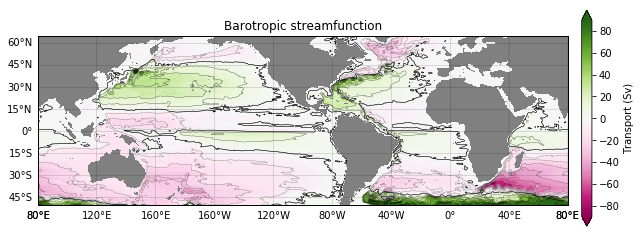

In [9]:
plt.figure(figsize(9.5,12))
levels = np.linspace(-200,200,21)
# print levels
clev = np.arange(-90,90.01,2)
clev2 = np.arange(-90,90.01,10)

plt.subplot(1,1,1)
map = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=65,\
            llcrnrlon=-280,urcrnrlon=80,resolution='l') # avoid tripole region north of 65N
map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
# map.drawcoastlines(linewidth=0.25)
# map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-60.,81.,15.),labels=[True,False,False,False],linewidth=0.25)
map.drawmeridians(np.arange(-160.,181.,40.),labels=[False,False,False,True],linewidth=0.25)
X, Y = map(geolon_t,geolat_t) 
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
p1=map.contourf(X,Y,gyre_psi, cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(0,200,20)
# print clev3
# map.contour(X,Y,gyre_psi,levels=clev3,colors='g',linewidths=1)
map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
plt.title('Barotropic streamfunction')

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('gyre_transport')

## Plot ACC transport

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


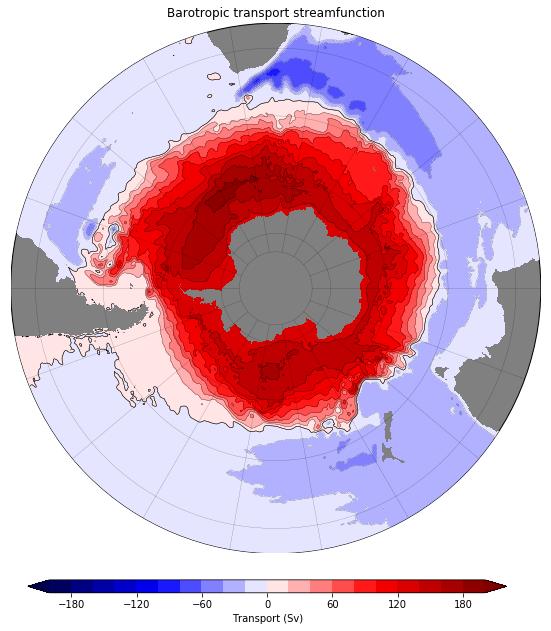

In [10]:
    
levels = np.linspace(-200,200,21)
# print levels

plt.figure(figsize(9.5,12))

plt.subplot(1,1,1)
# map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map = Basemap(projection ='spstere',boundinglat=-25,lon_0=-150,resolution='l',round=True)
map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
# map.drawcoastlines(linewidth=0.25)
# map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-90.,91.,15.),linewidth=0.25)
map.drawmeridians(np.arange(-160.,181.,20.),labels=[0,0,0,0],linewidth=0.25)
X, Y = map(geolon_t,geolat_t) 
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
p1=map.contourf(X,Y,gyre_psi, cmap=plt.cm.seismic, levels=levels, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(-200,200,20)
# print clev3
map.contour(X,Y,gyre_psi,levels=clev3,colors='k',linewidths=0.25)
map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
plt.title('Barotropic transport streamfunction')

ax3 = plt.axes([0.15,0.15,.7,0.015])
cb = plt.colorbar(p1,cax=ax3,orientation='horizontal')
cb.ax.set_xlabel('Transport (Sv)')

savefigure('ACC_transport_2')

cf. [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1) fig 9:

![](https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/phoc/2016/15200485-46.1/jpo-d-15-0046.1/20160222/images/large/jpo-d-15-0046.1-f9.jpeg)

## Plot Kuroshio transport, with DP transport subtracted

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


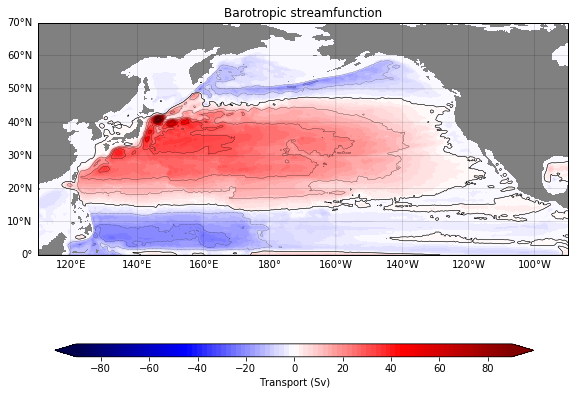

In [11]:
# gyre_psi = -cntrl_psi+cntrl_dp_ts

plt.figure(figsize(9.5,12))
levels = np.linspace(-200,200,21)
# print levels
clev = np.arange(-90,90.1,2)
clev2 = np.arange(-90,90.1,10)

plt.subplot(1,1,1)
map = Basemap(projection='cyl',llcrnrlat=0,urcrnrlat=70,\
            llcrnrlon=-250,urcrnrlon=-90,resolution='l') # WARNING: includes tripole region north of 65N
map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
# map.drawcoastlines(linewidth=0.25)
# map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
X, Y = map(geolon_t,geolat_t) 
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.PiYG, levels=levels, extend='both') #CMRmap_r, gist_stern_r
p1=map.contourf(X,Y,gyre_psi, cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(0,200,20)
# print clev3
# map.contour(X,Y,gyre_psi,levels=clev3,colors='g',linewidths=1)
map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
plt.title('Barotropic streamfunction')

ax3 = plt.axes([0.15,0.25,.7,0.015])
cb = plt.colorbar(p1,cax=ax3,orientation='horizontal')
cb.ax.set_xlabel('Transport (Sv)')
savefigure('Kuroshio_transport')

cf. [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1) fig 7:

![](https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/phoc/2016/15200485-46.1/jpo-d-15-0046.1/20160222/images/large/jpo-d-15-0046.1-f7.jpeg)

## Plot Gulf Stream transport, with DP transport subtracted

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


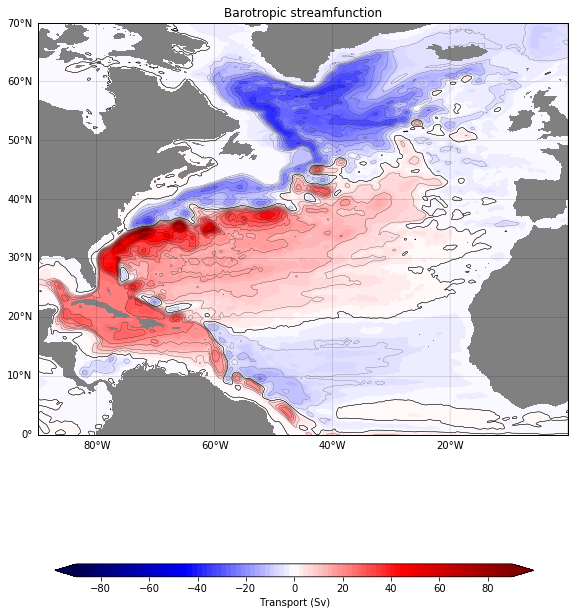

In [12]:
# gyre_psi = -cntrl_psi+cntrl_dp_ts

plt.figure(figsize(9.5,12))
levels = np.linspace(-200,200,21)
# print levels
clev = np.arange(-90,90.1,2)
clev2 = np.arange(-90,90.1,5)

plt.subplot(1,1,1)
map = Basemap(projection='cyl',llcrnrlat=0,urcrnrlat=70,\
            llcrnrlon=-90,urcrnrlon=0,resolution='l') # WARNING: includes tripole region north of 65N
map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
# map.drawcoastlines(linewidth=0.25)
# map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
X, Y = map(geolon_t,geolat_t) 
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
p1=map.contourf(X,Y,gyre_psi, cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(0,200,20)
# print clev3
# map.contour(X,Y,gyre_psi,levels=clev3,colors='g',linewidths=1)
map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
plt.title('Barotropic streamfunction')

ax3 = plt.axes([0.15,0.1,.7,0.015])
cb = plt.colorbar(p1,cax=ax3,orientation='horizontal')
cb.ax.set_xlabel('Transport (Sv)')
savefigure('GulfStream_transport')

cf. [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1) fig 3:

![](https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/phoc/2016/15200485-46.1/jpo-d-15-0046.1/20160222/images/large/jpo-d-15-0046.1-f3.jpeg)